In [1]:
from time import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from tqdm import tqdm_notebook
import torch.nn.functional as F
import torch.autograd as autograd
import pandas as pd
import gc
import scipy
import torch.nn.init as init
import seaborn as sns
import torch.distributions
from numpy.random import shuffle

from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom
import FrEIA.framework as Ff
import FrEIA.modules as Fm

from tools import *

import importlib
import tools
importlib.reload(tools)
from tools import *

import validation_tools
importlib.reload(validation_tools)
from validation_tools import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
from IPython.display import clear_output

In [2]:
obs_real = np.loadtxt("./data/new_obs_real.txt")
obs_std = np.loadtxt("./data/new_obs_err.txt")
obs_real = obs_real[:167]
obs_std = obs_std[:167]
obs_min = np.loadtxt('./data/new_obs_min_0.txt')
obs_inter = np.loadtxt('./data/new_obs_inter_0.txt')
obs_real = obs_real[:167]
obs_std = obs_std[:167]
obs_t_real = np.array([1.31929,1.43845,1.75019,1.92525,2.10340,
                       3.09907,3.25352,
                      2.29528,2.48487,2.75300,2.91257,3.83052,4.01381,
                      4.19269,4.36875,
                      3.20008,3.60368,5.05139,4.77537])*1000.
obs_t_std = np.array([0.17e-3, 0.08e-3,0.13e-3,0.12e-3,0.06e-3,
                     0.10e-3,0.06e-3,
                    0.22e-3,0.15e-3,0.33e-3,0.08e-3,0.21e-3,0.24e-3,0.22e-3,
                     0.53e-3,
                     1.73e-3,0.24e-3,0.23e-3,1.86e-3])*1000.
obs_real = np.concatenate([obs_real,obs_t_real])
obs_std = np.concatenate([obs_std,obs_t_std])

In [3]:
model_syn = np.loadtxt('./data/new_model_syn_0.txt')
obs_normal = np.loadtxt('./data/new_obs_normal_0.txt')

In [140]:
obs_test = (obs_normal+1.)/2.*obs_inter+obs_min
diff = (obs_test-obs_real)/(obs_std)

In [5]:
np.where(diff.mean(axis=0)- diff.std(axis=0)>0), np.where(diff.mean(axis=0) + diff.std(axis=0)<0)

((array([], dtype=int64),), (array([], dtype=int64),))

In [6]:
TOTAL_SAMPLE = obs_normal.shape[0]
INPUT_SIZE = obs_normal.shape[1]
OUTPUT_SIZE = model_syn.shape[1]

INPUT_SIZE = OUTPUT_SIZE

TRAIN_SIZE = int(0.95*TOTAL_SAMPLE)
TEST_SIZE = TOTAL_SAMPLE - TRAIN_SIZE

x_train = torch.tensor(obs_normal[:TRAIN_SIZE,:INPUT_SIZE],dtype=torch.float32)
x_test = torch.tensor(obs_normal[-TEST_SIZE:,:INPUT_SIZE],dtype=torch.float32)
y_train = torch.tensor(model_syn[:TRAIN_SIZE,:INPUT_SIZE],dtype=torch.float32)
y_test = torch.tensor(model_syn[-TEST_SIZE:,:INPUT_SIZE],dtype=torch.float32)

Obs_Size = INPUT_SIZE
Model_Size = OUTPUT_SIZE

In [7]:
BATCH_SIZE = 256
train_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_train,y_train),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test,y_test),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Forward net

In [29]:
# Train a flow model to approximate the forward mapping.
Forward_net = Flow(INPUT_SIZE).cuda()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(Forward_net.parameters(), lr=1e-3, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)

In [27]:
def train(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch,(X,y) in enumerate(dataloader):
        y,X = X.to(device),y.to(device)
        pred_obs = model(X)[0]
        loss_obs = loss_fn(pred_obs,y)
        #pred_ert = model(y,rev=True,jac=False)[0]
        #loss_ert = loss_fn(pred_ert,X)
        #loss = (loss_obs + loss_ert)/2.
        loss = loss_obs
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss,current = loss.item(), (batch+1)*len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [28]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            y, X = X.to(device), y.to(device)
            pred_obs = model(X)[0]
            loss_obs = loss_fn(pred_obs,y)
            #pred_ert = model(y,rev=True,jac=False)[0]
            #loss_ert = loss_fn(pred_ert,X)
            #loss = (loss_obs + loss_ert)/2.
            loss = loss_obs
            test_loss += loss.item()
            
    test_loss /= num_batches
    print(f"Test Error:  Avg loss: {test_loss:>8f} \n")

In [30]:
epochs = 4
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_data, Forward_net, loss_fn, optimizer)
    test(test_data, Forward_net, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.247173  [  256/89921]
loss: 0.926413  [ 2816/89921]
loss: 0.766583  [ 5376/89921]
loss: 0.669400  [ 7936/89921]
loss: 0.620883  [10496/89921]
loss: 0.568786  [13056/89921]
loss: 0.504699  [15616/89921]
loss: 0.438726  [18176/89921]
loss: 0.376834  [20736/89921]
loss: 0.345293  [23296/89921]
loss: 0.303123  [25856/89921]
loss: 0.284106  [28416/89921]
loss: 0.269013  [30976/89921]
loss: 0.247452  [33536/89921]
loss: 0.239127  [36096/89921]
loss: 0.228517  [38656/89921]
loss: 0.213748  [41216/89921]
loss: 0.209415  [43776/89921]
loss: 0.202524  [46336/89921]
loss: 0.189041  [48896/89921]
loss: 0.182120  [51456/89921]
loss: 0.173735  [54016/89921]
loss: 0.168121  [56576/89921]
loss: 0.159618  [59136/89921]
loss: 0.155404  [61696/89921]
loss: 0.151686  [64256/89921]
loss: 0.143497  [66816/89921]
loss: 0.140643  [69376/89921]
loss: 0.134715  [71936/89921]
loss: 0.127293  [74496/89921]
loss: 0.122131  [77056/89921]
loss: 0.117633  [79616/89921]


In [34]:
#save 
filename = './net/Forward_net.pth'
torch.save(Forward_net.state_dict(),filename)

In [35]:
INPUT_SIZE= 152
OUTPUT_SIZE = 152

In [36]:
#reload
filename = './net/Forward_net.pth'
Forward_net = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Forward_net.load_state_dict(state)
Forward_net.eval();

# generate dataset

In [37]:
INPUT_SIZE= 152
OUTPUT_SIZE = 152

uni_dis = torch.distributions.uniform.Uniform(-torch.ones(INPUT_SIZE),torch.ones(INPUT_SIZE))
SAMPL_SIZE = 2000
model0_train = uni_dis.sample((100*SAMPL_SIZE,))
obs0_train = uni_dis.sample((100*SAMPL_SIZE,))
for num in range(100):
    obs0_train[num*SAMPL_SIZE:(num+1)*SAMPL_SIZE]= Forward_net(model0_train[num*SAMPL_SIZE:(num+1)*SAMPL_SIZE].to(device))[0].detach().cpu()
model0_test = uni_dis.sample((SAMPL_SIZE,))
obs0_test = Forward_net(model0_test.to(device))[0].detach().cpu()

In [38]:
BATCH_SIZE = 256
train0_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(obs0_train,model0_train),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test0_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(obs0_test,model0_test),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [39]:
obs_real_normal = (obs_real-obs_min)/obs_inter*2.-1.
obs_fix = torch.randn(BATCH_SIZE,OUTPUT_SIZE)
obs_fix[:] = torch.tensor(obs_real_normal[:OUTPUT_SIZE],dtype=torch.float32)
model_fix = Forward_net(obs_fix.to(device),rev=True,jac=False)[0].detach().cpu()

In [40]:
BATCH_SIZE = 256
uni_dis = torch.distributions.uniform.Uniform(-torch.ones(INPUT_SIZE),torch.ones(INPUT_SIZE))
var_np = obs_std/obs_inter*2.
var_np = var_np[:INPUT_SIZE]

# Tranditional Flow

In [52]:
#the normalization flow of observation
Obs_Normal_Flow_s0 = Flow(INPUT_SIZE).cuda()
opt_obs = torch.optim.Adam(Obs_Normal_Flow_s0.parameters(), lr=1e-3, betas=(0.8, 0.9),
                             eps=1e-6, weight_decay=1e-5)

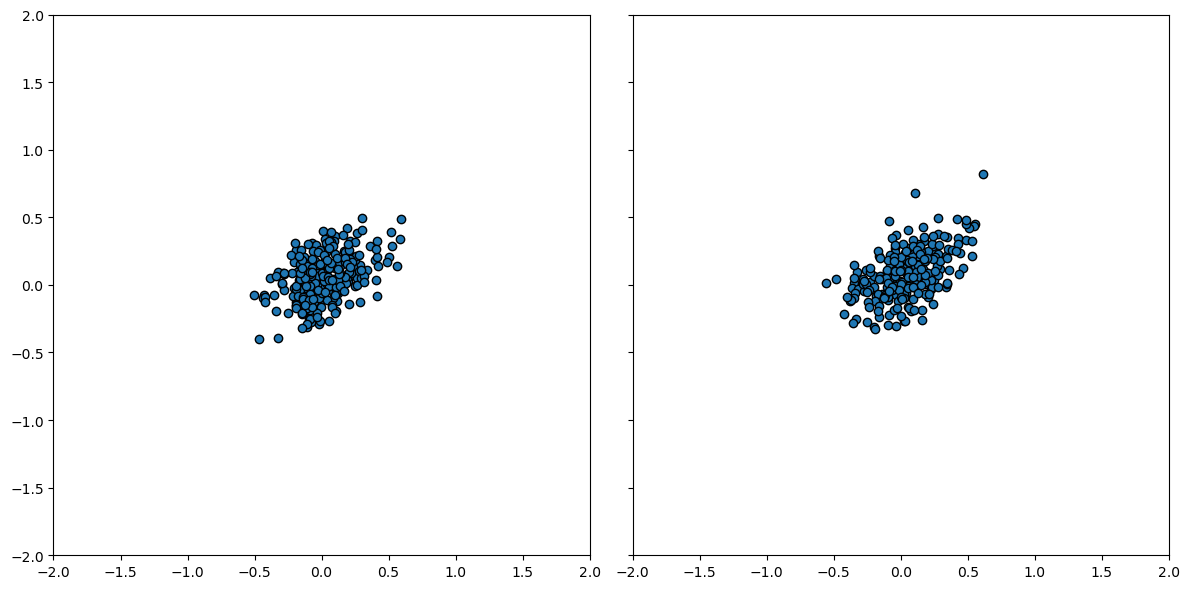

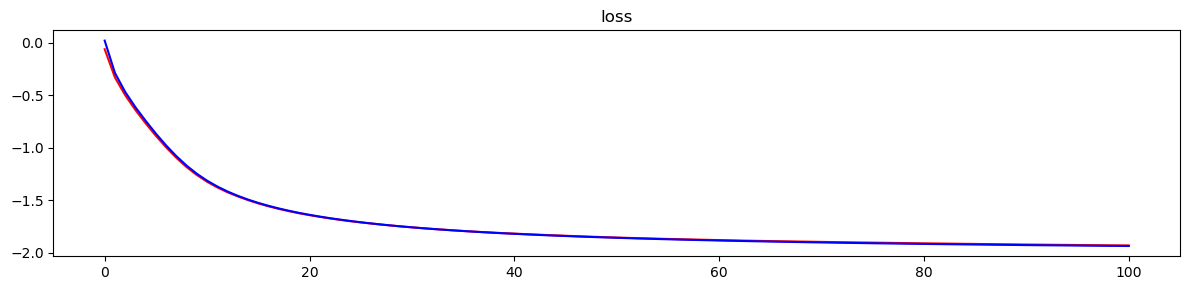

100%|█████████████████████████████████████| 10001/10001 [07:43<00:00, 21.57it/s]


In [53]:
train_obs_normalization(Obs_Normal_Flow_s0,opt_obs,train0_data,var_np,test0_data,label=False,epochs=10001)

In [54]:
#save
filename = './net/Obs_normal_0_val.pth'
torch.save(Obs_Normal_Flow_s0.state_dict(),filename)

In [55]:
#reload
filename = './net/Obs_normal_0_val.pth'
Obs_Normal_Flow_s0 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Obs_Normal_Flow_s0.load_state_dict(state)
Obs_Normal_Flow_s0.eval();

In [56]:
Inverse_flow0 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
opt_inv = torch.optim.Adam(Inverse_flow0.parameters(), lr=5e-3, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)

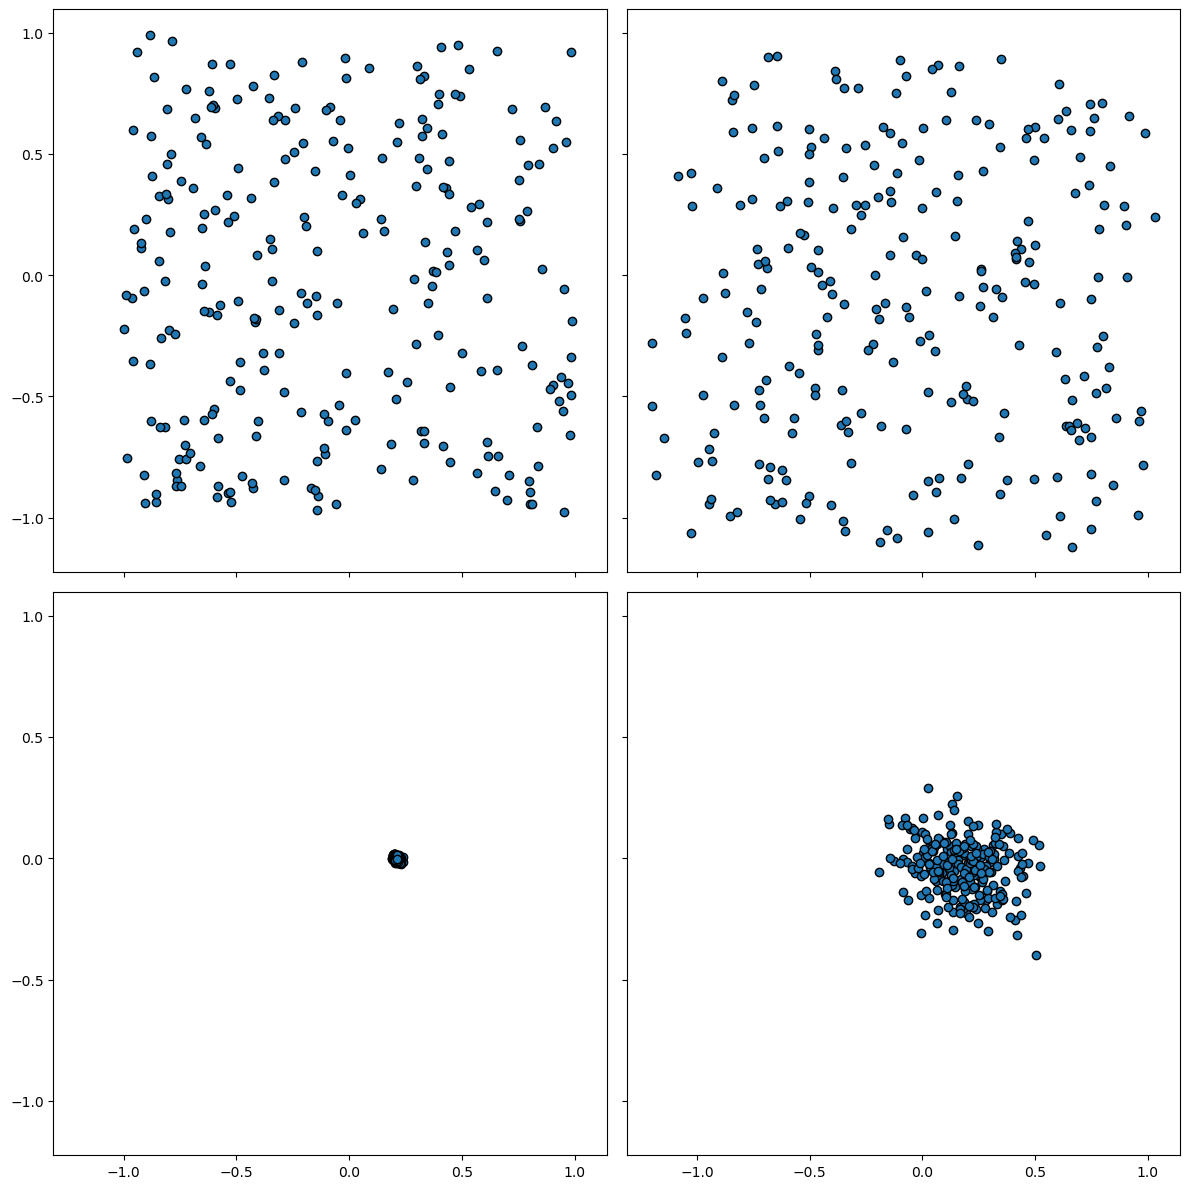

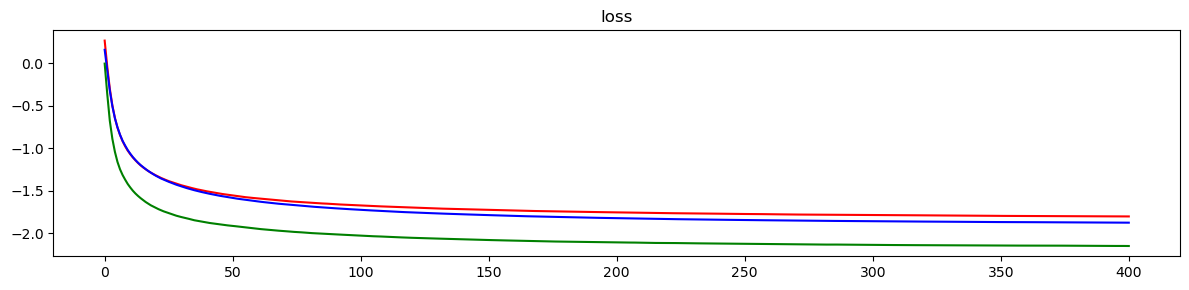

100%|█████████████████████████████████████| 40001/40001 [36:02<00:00, 18.50it/s]


In [57]:
cross_entropy1,cross_entropy2 = train_inverse_flow_original2_validation(Inverse_flow0,opt_inv,train0_data,var_np,obs_fix,test0_data,ert_sample,epochs=40001)

In [58]:
#save flow 
filename = './net/Inverse_flow_val.pth'
torch.save(Inverse_flow0.state_dict(),filename)

In [59]:
#save crossentropy
np.savetxt('./data/cross_entorpy1.txt',np.array(cross_entropy1))
np.savetxt('./data/cross_entorpy2.txt',np.array(cross_entropy2))

# INFM

## generate data

In [61]:
INPUT_SIZE= 152
OUTPUT_SIZE = 152

uni_dis = torch.distributions.uniform.Uniform(-torch.ones(INPUT_SIZE),torch.ones(INPUT_SIZE))
SAMPL_SIZE = 2000
model1_train = uni_dis.sample((25*SAMPL_SIZE,))
obs1_train = uni_dis.sample((25*SAMPL_SIZE,))
for num in range(25):
    obs1_train[num*SAMPL_SIZE:(num+1)*SAMPL_SIZE]= Forward_net(model1_train[num*SAMPL_SIZE:(num+1)*SAMPL_SIZE].to(device))[0].detach().cpu()
model1_test = uni_dis.sample((SAMPL_SIZE,))
obs1_test = Forward_net(model1_test.to(device))[0].detach().cpu()

In [62]:
BATCH_SIZE = 256
train1_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(obs1_train,model1_train),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test1_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(obs1_test,model1_test),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# 1-Step

In [65]:
Inverse_flow1 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
opt_inv = torch.optim.Adam(Inverse_flow1.parameters(), lr=5e-3, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)

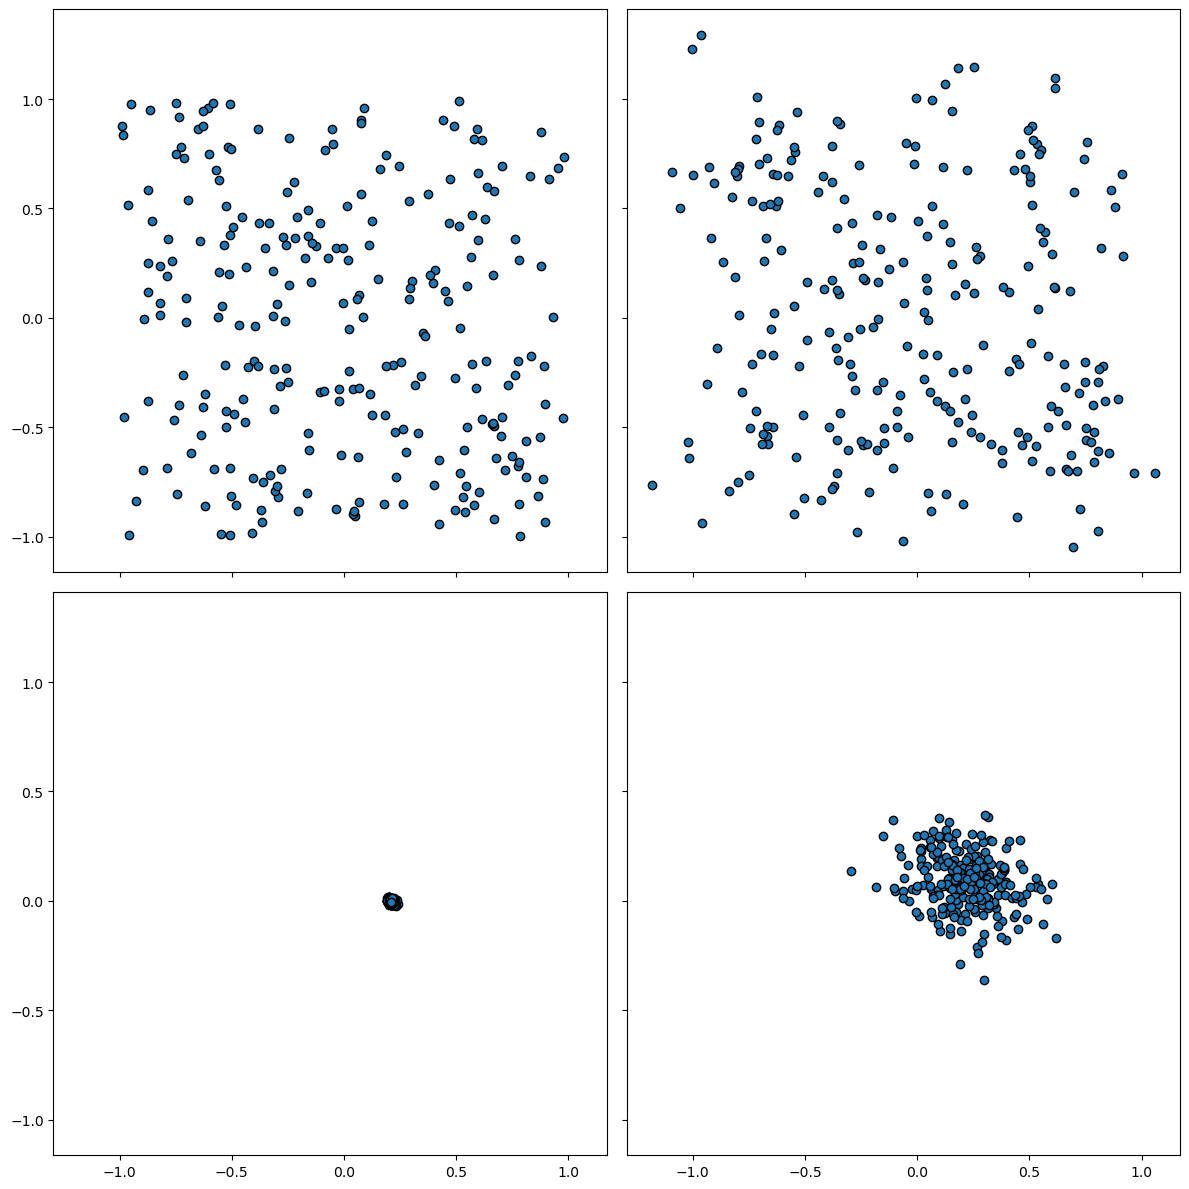

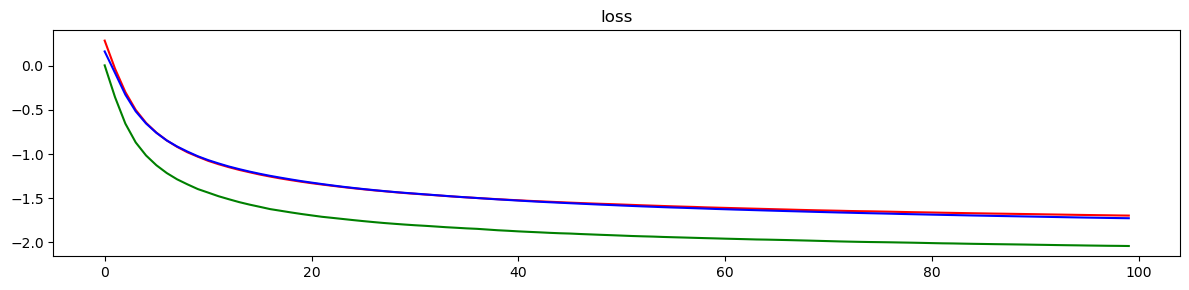

100%|███████████████████████████████████████| 9999/9999 [07:05<00:00, 23.49it/s]


In [66]:
cross_entropy1_1,cross_entropy2_1 = train_inverse_flow_original2_validation(Inverse_flow1,opt_inv,train1_data,var_np,obs_fix,test1_data,ert_sample,epochs=9999)

In [67]:
np.savetxt('./data/cross_entorpy1_1.txt',np.array(cross_entropy1_1))
np.savetxt('./data/cross_entorpy2_1.txt',np.array(cross_entropy2_1))

In [68]:
#
filename = './net/Inverse_flow1_1_val.pth'
torch.save(Inverse_flow1.state_dict(),filename)

In [69]:
#
filename = './net/Inverse_flow1_1_val.pth'
Inverse_flow1 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
state = torch.load(filename)
Inverse_flow1.load_state_dict(state)
Inverse_flow1.eval();

In [70]:
INPUT_SIZE= 152
OUTPUT_SIZE = 152

uni_dis = torch.distributions.uniform.Uniform(-torch.ones(INPUT_SIZE),torch.ones(INPUT_SIZE))
SAMPL_SIZE = 2000
model2_train = uni_dis.sample((25*SAMPL_SIZE,))
obs2_train = uni_dis.sample((25*SAMPL_SIZE,))
obs_fixed = torch.randn(SAMPL_SIZE,INPUT_SIZE,device=device)
obs_fixed[:] = torch.tensor(obs_fix)[0]

for num in range(25):
    rand_ert = torch.randn(SAMPL_SIZE,OUTPUT_SIZE,device=device)
    ert_fake = Inverse_flow1(rand_ert,obs_fixed.to(device),rev=True,jac=False)[0]
    model2_train[num*SAMPL_SIZE:(num+1)*SAMPL_SIZE] = ert_fake.detach().cpu()
    obs2_train[num*SAMPL_SIZE:(num+1)*SAMPL_SIZE] = Forward_net(ert_fake)[0].detach().cpu()

rand_ert = torch.randn(SAMPL_SIZE,OUTPUT_SIZE,device=device)
ert_fake = Inverse_flow1(rand_ert,obs_fixed.to(device),rev=True,jac=False)[0]
model2_test = ert_fake.detach().cpu()
obs2_test = Forward_net(model2_test.to(device))[0].detach().cpu()

obs2_max = (np.max(obs2_train.numpy(),axis=0)).reshape(obs2_train.shape[1])
obs2_min = np.min(obs2_train.numpy(),axis=0).reshape(obs2_train.shape[1])
obs2_inter = obs2_max - obs2_min
obs2_train_normal = (obs2_train - obs2_min)/obs2_inter*2.-1.
obs2_test_normal = (obs2_test - obs2_min)/obs2_inter*2.-1.

BATCH_SIZE = 256
train2_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(obs2_train_normal,model2_train),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test2_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(obs2_test_normal,model2_test),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/tmp/ipykernel_19886/830129496.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_fixed[:] = torch.tensor(obs_fix)[0]


In [71]:
var_np2 = var_np/obs2_inter*2.
obs_fix2 = (obs_fix-obs2_min)/obs2_inter*2.-1.

# Step 2

In [72]:
Obs_Normal_Flow_s2 = Flow(INPUT_SIZE).cuda()
opt_obs = torch.optim.Adam(Obs_Normal_Flow_s2.parameters(), lr=1e-3, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)

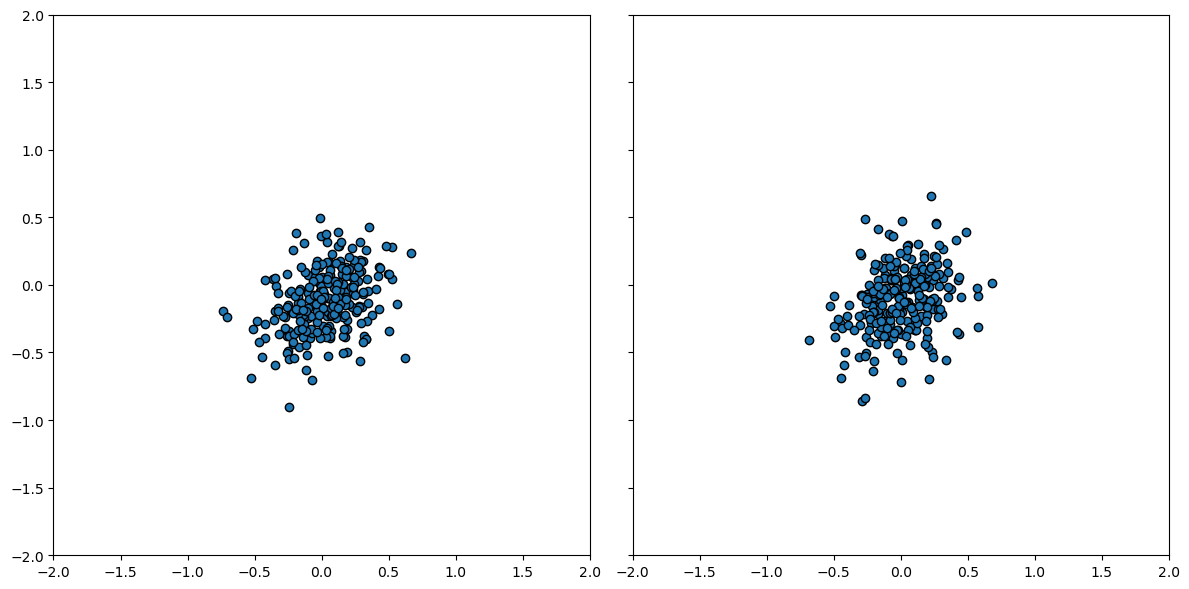

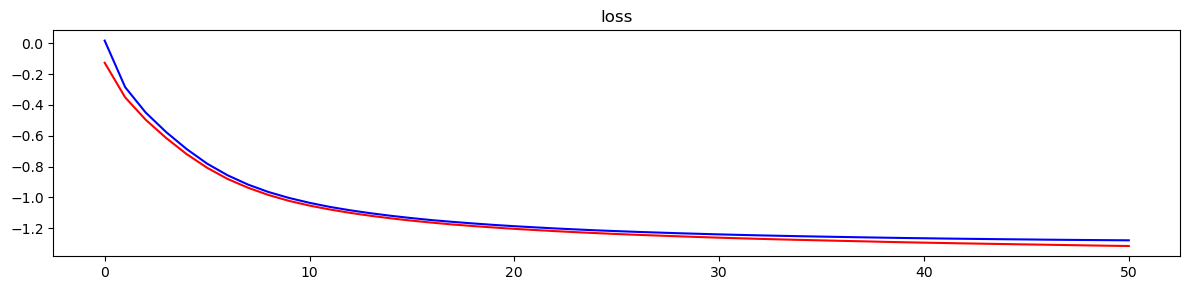

100%|███████████████████████████████████████| 5001/5001 [03:22<00:00, 24.70it/s]


In [73]:
train_obs_normalization(Obs_Normal_Flow_s2,opt_obs,train2_data,var_np2,test2_data,label=False,epochs=5001)

In [74]:
filename = './net/Obs_normal_2_val.pth'
torch.save(Obs_Normal_Flow_s2.state_dict(),filename)

In [75]:
filename = './net/Obs_normal_2_val.pth'
Obs_Normal_Flow_s2 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Obs_Normal_Flow_s2.load_state_dict(state)
Obs_Normal_Flow_s2.eval();

In [76]:
Mod_Normal_Flow_s2 = Flow(OUTPUT_SIZE).cuda()
opt_mod = torch.optim.Adam(Mod_Normal_Flow_s2.parameters(), lr=5e-3)

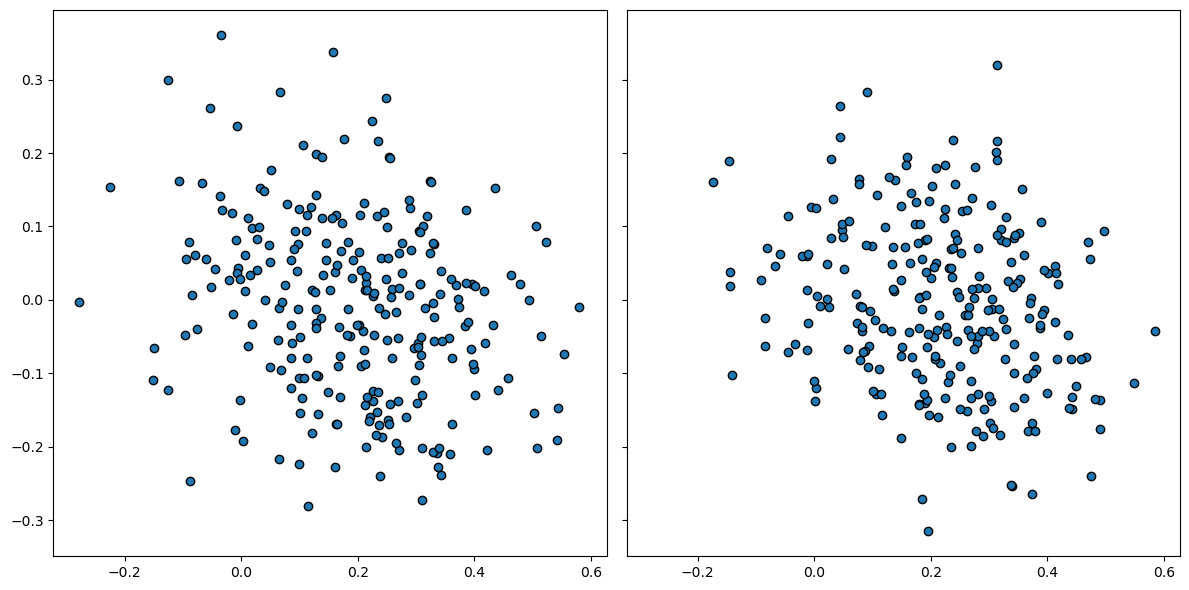

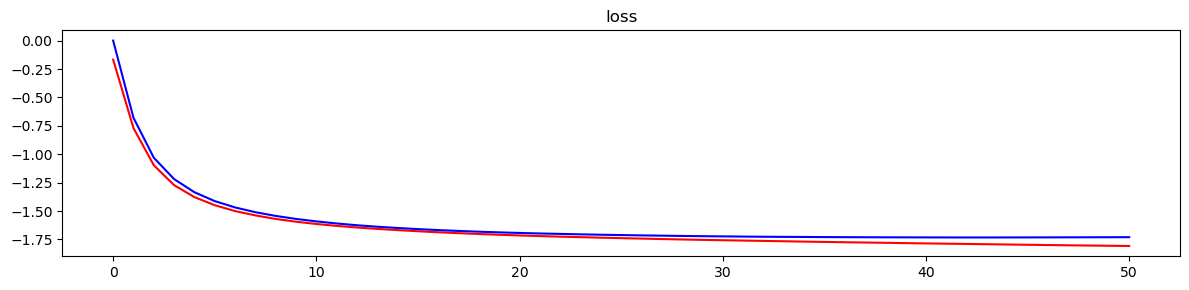

100%|███████████████████████████████████████| 5001/5001 [03:06<00:00, 26.77it/s]


In [77]:
train_mod_normalization(Mod_Normal_Flow_s2,opt_mod,train2_data,var_np,test2_data,label=False,epochs=5001)

In [78]:
filename = './net/Mod_normal_2_val.pth'
torch.save(Mod_Normal_Flow_s2.state_dict(),filename)

In [79]:
filename = './net/Mod_normal_2_val.pth'
Mod_Normal_Flow_s2 = Flow(OUTPUT_SIZE).cuda()
state = torch.load(filename)
Mod_Normal_Flow_s2.load_state_dict(state)
Mod_Normal_Flow_s2.eval();

In [80]:
Inverse_flow_s2 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
opt_inv = torch.optim.Adam(Inverse_flow_s2.parameters(),lr=5e-3, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)

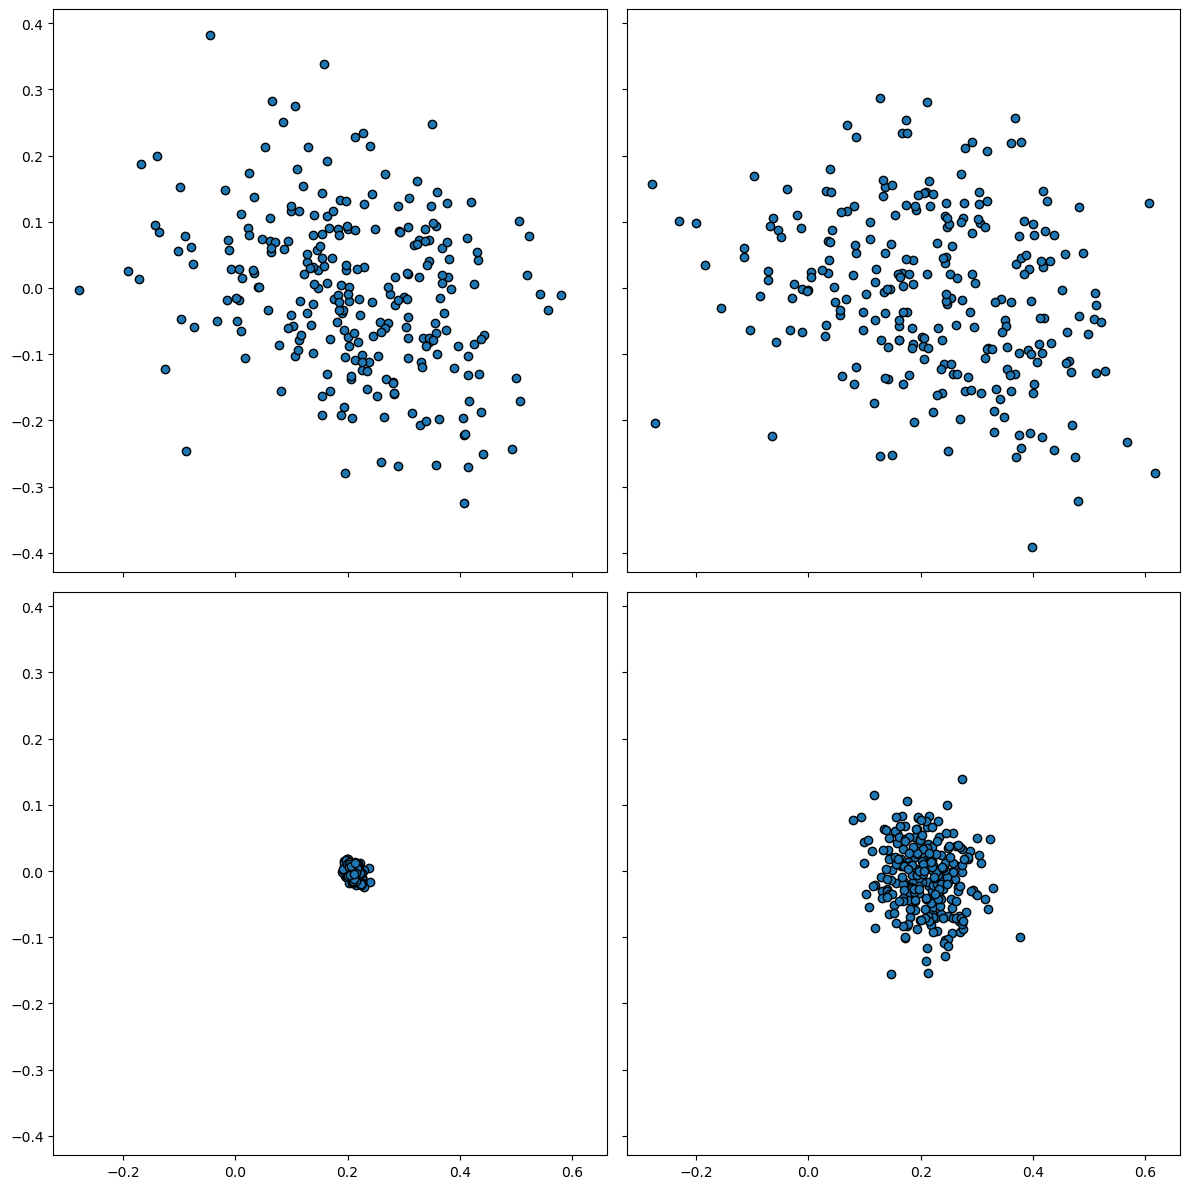

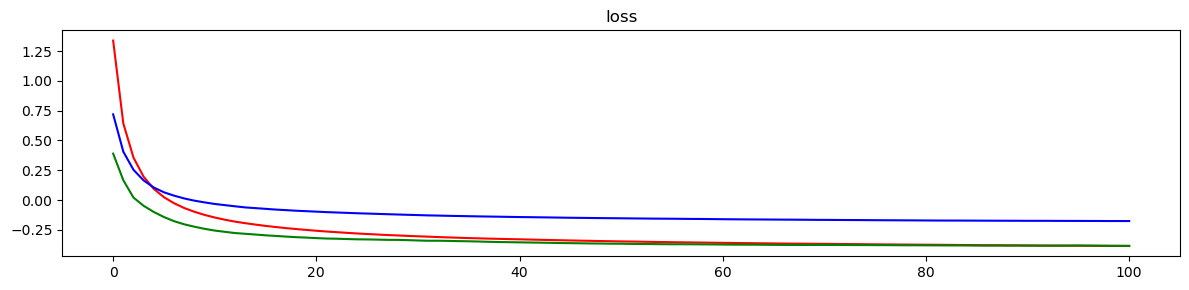

100%|█████████████████████████████████████| 10001/10001 [11:18<00:00, 14.74it/s]


In [81]:
cross_entropy2_1,cross_entropy2_2 = train_inverse_flow_validation(Obs_Normal_Flow_s2,Mod_Normal_Flow_s2,Inverse_flow_s2,opt_inv,train2_data,var_np2,obs_fix2,test2_data,ert_sample,label=False,epochs=10001)

In [82]:
np.savetxt('./data/cross_entorpy1_2.txt',np.array(cross_entropy2_1))
np.savetxt('./data/cross_entorpy2_2.txt',np.array(cross_entropy2_2))

In [83]:
filename = './net/Inverse_flow_s2_val.pth'
torch.save(Inverse_flow_s2.state_dict(),filename)

In [84]:
filename = './net/Inverse_flow_s2_val.pth'
Inverse_flow_s2 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
state = torch.load(filename)
Inverse_flow_s2.load_state_dict(state)
Inverse_flow_s2.eval();

In [85]:
uni_dis = torch.distributions.uniform.Uniform(-torch.ones(INPUT_SIZE),torch.ones(INPUT_SIZE))
SAMPL_SIZE = 2000
model3_train = uni_dis.sample((25*SAMPL_SIZE,))
obs3_train = uni_dis.sample((25*SAMPL_SIZE,))
obs_fixed = torch.randn(SAMPL_SIZE,INPUT_SIZE,device=device)
obs_fixed[:] = torch.tensor(obs_fix2)[0]
obs_code = Obs_Normal_Flow_s2(obs_fixed.to(device))[0]

for num in range(25):
    rand_ert = torch.randn(SAMPL_SIZE,OUTPUT_SIZE,device=device)
    ert_fake_code = Inverse_flow_s2(rand_ert,obs_code,rev=True,jac=False)[0].detach()
    ert_fake = Mod_Normal_Flow_s2(ert_fake_code,rev=True,jac=False)[0].detach()
    model3_train[num*SAMPL_SIZE:(num+1)*SAMPL_SIZE] = ert_fake.detach().cpu()
    obs3_train[num*SAMPL_SIZE:(num+1)*SAMPL_SIZE] = Forward_net(ert_fake)[0].detach().cpu()

rand_ert = torch.randn(SAMPL_SIZE,OUTPUT_SIZE,device=device)
ert_fake_code = Inverse_flow_s2(rand_ert,obs_code,rev=True,jac=False)[0].detach()
ert_fake = Mod_Normal_Flow_s2(ert_fake_code,rev=True,jac=False)[0].detach()
model3_test = ert_fake.detach().cpu()
obs3_test = Forward_net(model3_test.to(device))[0].detach().cpu()

obs3_max = (np.max(obs3_train.numpy(),axis=0)).reshape(obs3_train.shape[1])
obs3_min = np.min(obs3_train.numpy(),axis=0).reshape(obs3_train.shape[1])
obs3_inter = obs3_max - obs3_min
obs3_train_normal = (obs3_train - obs3_min)/obs3_inter*2.-1.
obs3_test_normal = (obs3_test - obs3_min)/obs3_inter*2.-1.

BATCH_SIZE = 256
train3_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(obs3_train_normal,model3_train),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test3_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(obs3_test_normal,model3_test),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/tmp/ipykernel_19886/1830872576.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_fixed[:] = torch.tensor(obs_fix2)[0]


In [86]:
var_np3 = var_np/obs3_inter*2.
#var3 = torch.tensor(obs_std[]/obs3_inter*2.,dtype=torch.float32)
#obs_fix3 = torch.tensor((obs_fix-obs_min1)/obs_inter1*2.-1.,device=device,dtype=torch.float32)
obs_fix3 = (obs_fix-obs3_min)/obs3_inter*2.-1.

# Step 3

In [88]:
Obs_Normal_Flow_s3 = Flow(INPUT_SIZE).cuda()
opt_obs = torch.optim.Adam(Obs_Normal_Flow_s3.parameters(), lr=5e-4, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)

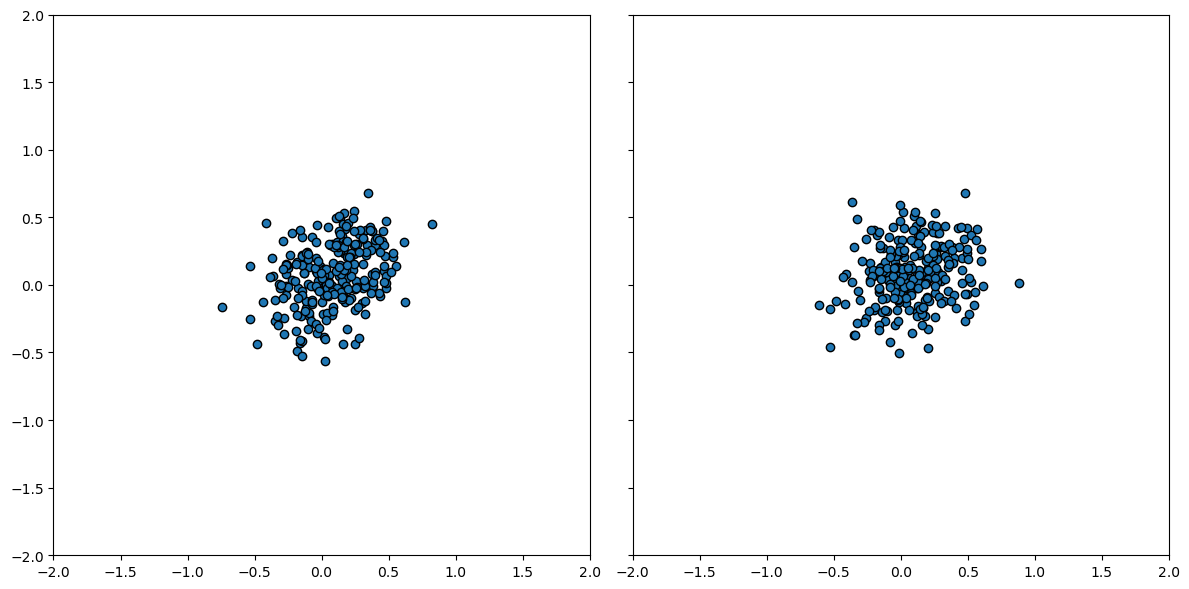

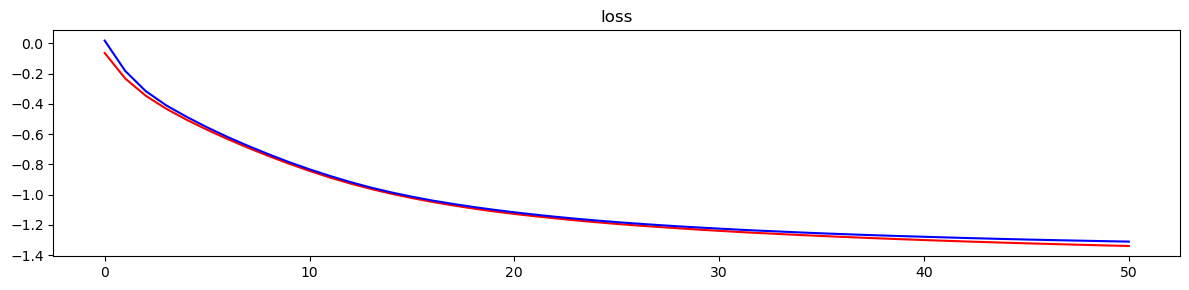

100%|███████████████████████████████████████| 5001/5001 [03:22<00:00, 24.71it/s]


In [89]:
train_obs_normalization(Obs_Normal_Flow_s3,opt_obs,train3_data,var_np3,test3_data,label=False,epochs=5001)

In [90]:
filename = './net/Obs_normal_3_val.pth'
torch.save(Obs_Normal_Flow_s3.state_dict(),filename)

In [91]:
filename = './net/Obs_normal_3_val.pth'
Obs_Normal_Flow_s3 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Obs_Normal_Flow_s3.load_state_dict(state)
Obs_Normal_Flow_s3.eval();

In [92]:
Mod_Normal_Flow_s3 = Flow(OUTPUT_SIZE).cuda()
opt_mod = torch.optim.Adam(Mod_Normal_Flow_s3.parameters(), lr=5e-3)

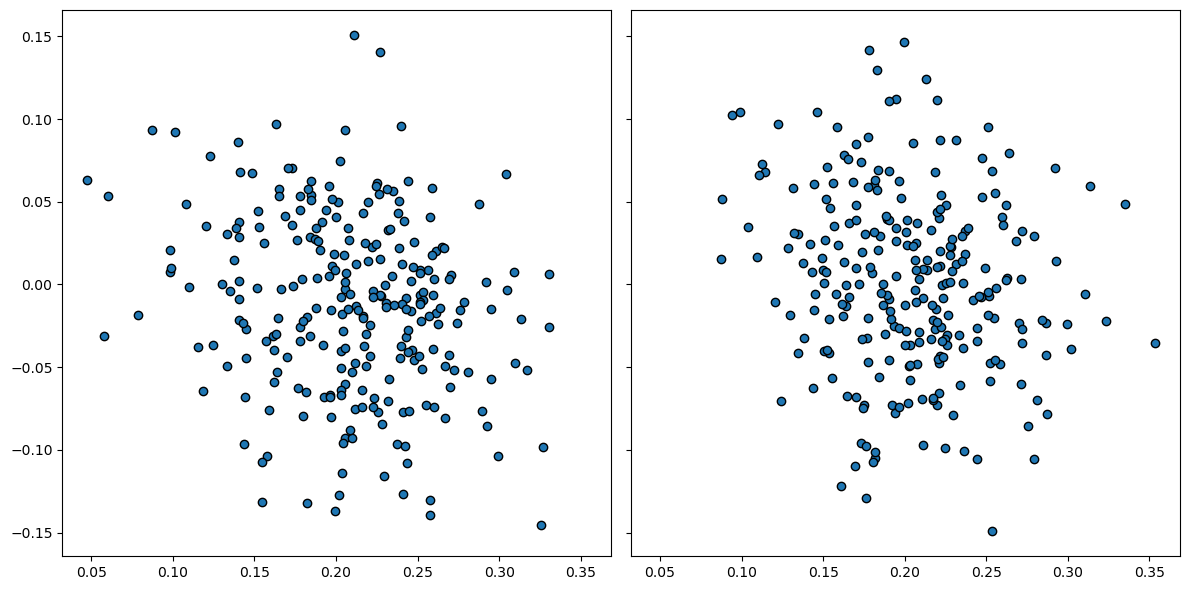

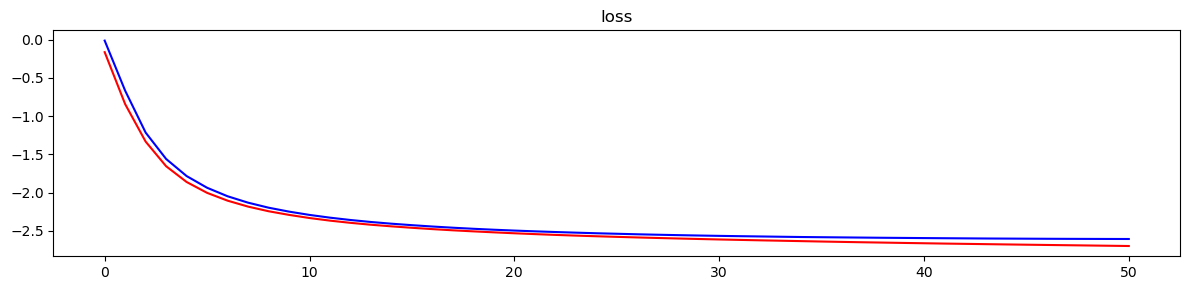

100%|███████████████████████████████████████| 5001/5001 [03:10<00:00, 26.30it/s]


In [93]:
train_mod_normalization(Mod_Normal_Flow_s3,opt_mod,train3_data,var_np3,test3_data,label=False,epochs=5001)

In [94]:
filename = './net/Mod_normal_3_val.pth'
torch.save(Mod_Normal_Flow_s3.state_dict(),filename)

In [95]:
filename = './net/Mod_normal_3_val.pth'
Mod_Normal_Flow_s3 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Mod_Normal_Flow_s3.load_state_dict(state)
Mod_Normal_Flow_s3.eval();

In [96]:
Inverse_flow_s3 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
opt_inv = torch.optim.Adam(Inverse_flow_s3.parameters(),lr=5e-3, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)

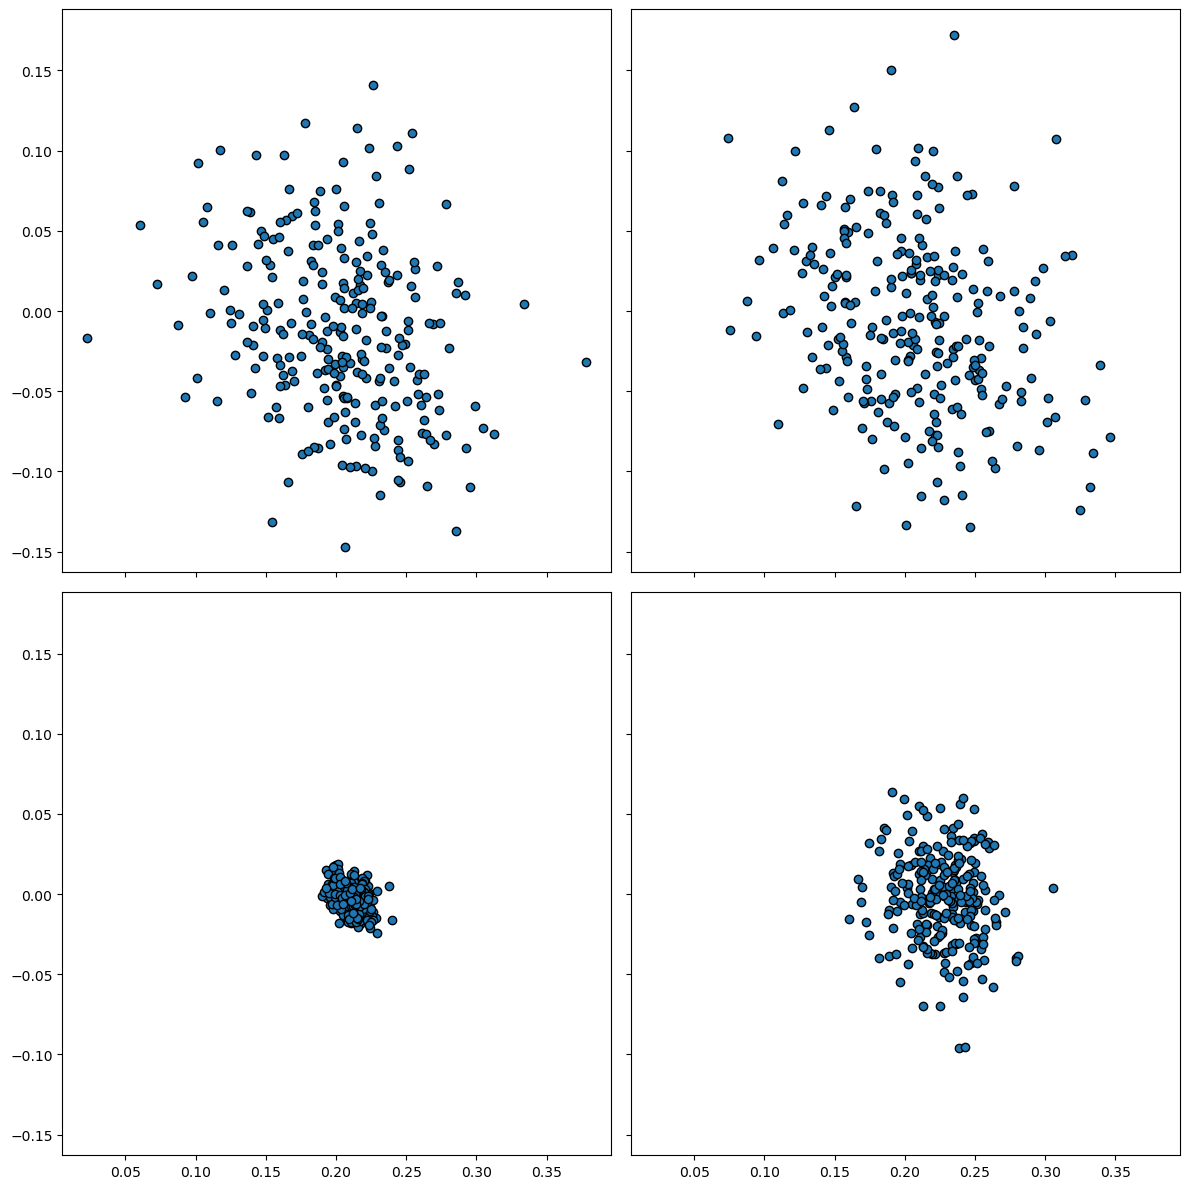

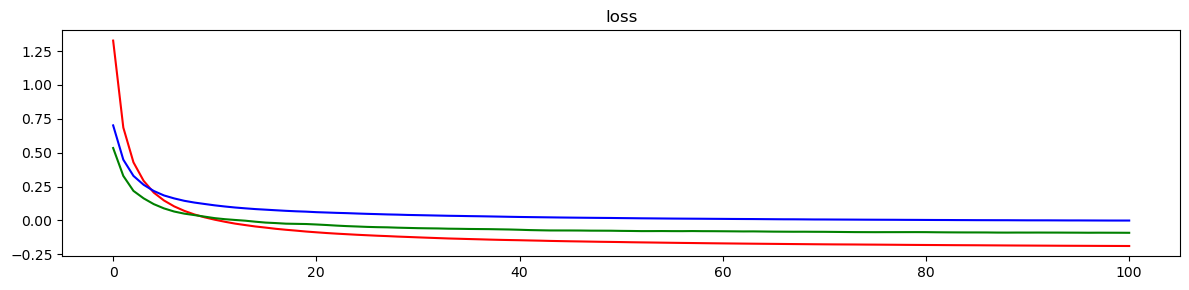

100%|█████████████████████████████████████| 10001/10001 [11:18<00:00, 14.74it/s]


In [97]:
cross_entropy3_1,cross_entropy3_2 = train_inverse_flow_validation(Obs_Normal_Flow_s3,Mod_Normal_Flow_s3,Inverse_flow_s3,opt_inv,train3_data,var_np3,obs_fix3,test3_data,ert_sample,label=False,epochs=10001)

In [98]:
filename = './net/Inverse_flow_s3_val.pth'
torch.save(Inverse_flow_s3.state_dict(),filename)

In [99]:
filename = './net/Inverse_flow_s3_val.pth'
Inverse_flow_s3 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
state = torch.load(filename)
Inverse_flow_s3.load_state_dict(state)
Inverse_flow_s3.eval();

In [100]:
np.savetxt('./data/cross_entorpy1_3.txt',np.array(cross_entropy3_1))
np.savetxt('./data/cross_entorpy2_3.txt',np.array(cross_entropy3_2))

In [102]:
uni_dis = torch.distributions.uniform.Uniform(-torch.ones(INPUT_SIZE),torch.ones(INPUT_SIZE))
SAMPL_SIZE = 2000
model4_train = uni_dis.sample((25*SAMPL_SIZE,))
obs4_train = uni_dis.sample((25*SAMPL_SIZE,))
weight4_train = torch.randn((25*SAMPL_SIZE))

obs_fixed = torch.randn(SAMPL_SIZE,INPUT_SIZE,device=device)
obs_fixed[:] = torch.tensor(obs_fix3)[0]
obs_code = Obs_Normal_Flow_s3(obs_fixed.to(device))[0]

for num in range(25):
    rand_ert = torch.randn(SAMPL_SIZE,OUTPUT_SIZE,device=device)
    ert_fake_code, log_jac_det = Inverse_flow_s3(rand_ert,obs_code,rev=True,jac=False)
    ert_fake,log_jac_det2 = Mod_Normal_Flow_s3(ert_fake_code,rev=True,jac=False)
    weight4_train[num*SAMPL_SIZE:(num+1)*SAMPL_SIZE] = ((0.5*torch.sum(rand_ert**2,1) + log_jac_det + log_jac_det2)/OUTPUT_SIZE).detach().cpu()
    
    model4_train[num*SAMPL_SIZE:(num+1)*SAMPL_SIZE] = ert_fake.detach().cpu()
    obs4_train[num*SAMPL_SIZE:(num+1)*SAMPL_SIZE] = Forward_net(ert_fake)[0].detach().cpu()

weight4_train = weight4_train-weight4_train.mean()
weight4_train = torch.exp(weight4_train)

rand_ert = torch.randn(SAMPL_SIZE,OUTPUT_SIZE,device=device)
ert_fake_code, log_jac_det = Inverse_flow_s3(rand_ert,obs_code,rev=True,jac=False)
ert_fake, log_jac_det2 = Mod_Normal_Flow_s3(ert_fake_code,rev=True,jac=False)
weight4_test = ((0.5*torch.sum(rand_ert**2,1) + log_jac_det + log_jac_det2)/OUTPUT_SIZE).detach().cpu()
weight4_test = weight4_test-weight4_train.mean()
weight4_test = torch.exp(weight4_test)

model4_test = ert_fake.detach().cpu()
obs4_test = Forward_net(model4_test.to(device))[0].detach().cpu()

obs4_max = (np.max(obs4_train.numpy(),axis=0)).reshape(obs4_train.shape[1])
obs4_min = np.min(obs4_train.numpy(),axis=0).reshape(obs4_train.shape[1])
obs4_inter = obs4_max - obs4_min
obs4_train_normal = (obs4_train - obs4_min)/obs4_inter*2.-1.
obs4_test_normal = (obs4_test - obs4_min)/obs4_inter*2.-1.

BATCH_SIZE = 256
train4_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(obs4_train_normal,model4_train,weight4_train),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test4_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(obs4_test_normal,model4_test,weight4_test),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/tmp/ipykernel_19886/459539186.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_fixed[:] = torch.tensor(obs_fix3)[0]


In [117]:
var_np4 = var_np/obs4_inter*2.
obs_fix4 = (obs_fix-obs4_min)/obs4_inter*2.-1.

# Step 4

In [104]:
Obs_Normal_Flow_s4 = Flow(INPUT_SIZE).cuda()
opt_obs = torch.optim.Adam(Obs_Normal_Flow_s4.parameters(), lr=5e-4, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)

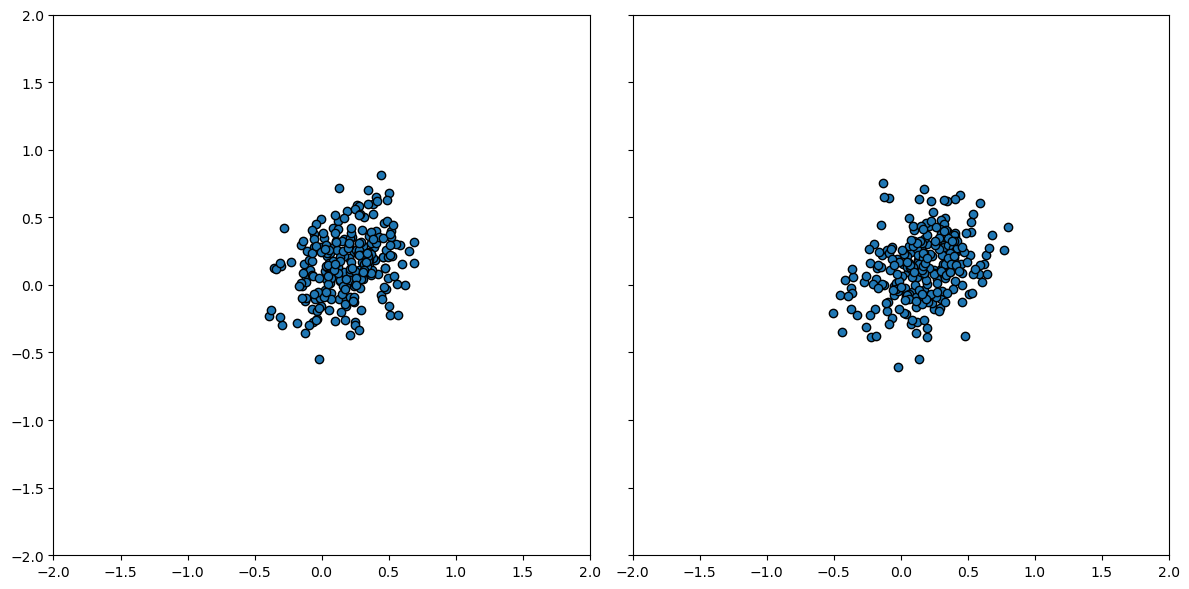

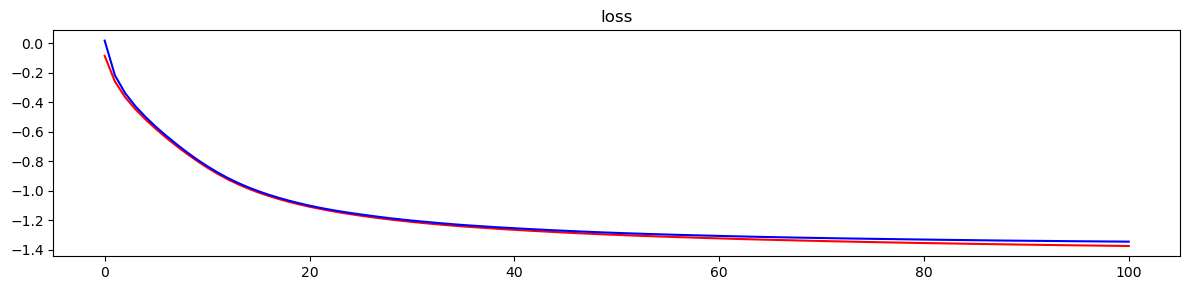

100%|█████████████████████████████████████| 10001/10001 [06:46<00:00, 24.62it/s]


In [106]:
train_obs_normalization(Obs_Normal_Flow_s4,opt_obs,train4_data,var_np4,test4_data,label=True,epochs=10001)

In [107]:
filename = './net/Obs_normal_4_val.pth'
torch.save(Obs_Normal_Flow_s4.state_dict(),filename)

In [108]:
filename = './net/Obs_normal_4_val.pth'
Obs_Normal_Flow_s4 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Obs_Normal_Flow_s4.load_state_dict(state)
Obs_Normal_Flow_s4.eval();

In [109]:
Mod_Normal_Flow_s4 = Flow(OUTPUT_SIZE).cuda()
opt_mod = torch.optim.Adam(Mod_Normal_Flow_s4.parameters(), lr=5e-3)

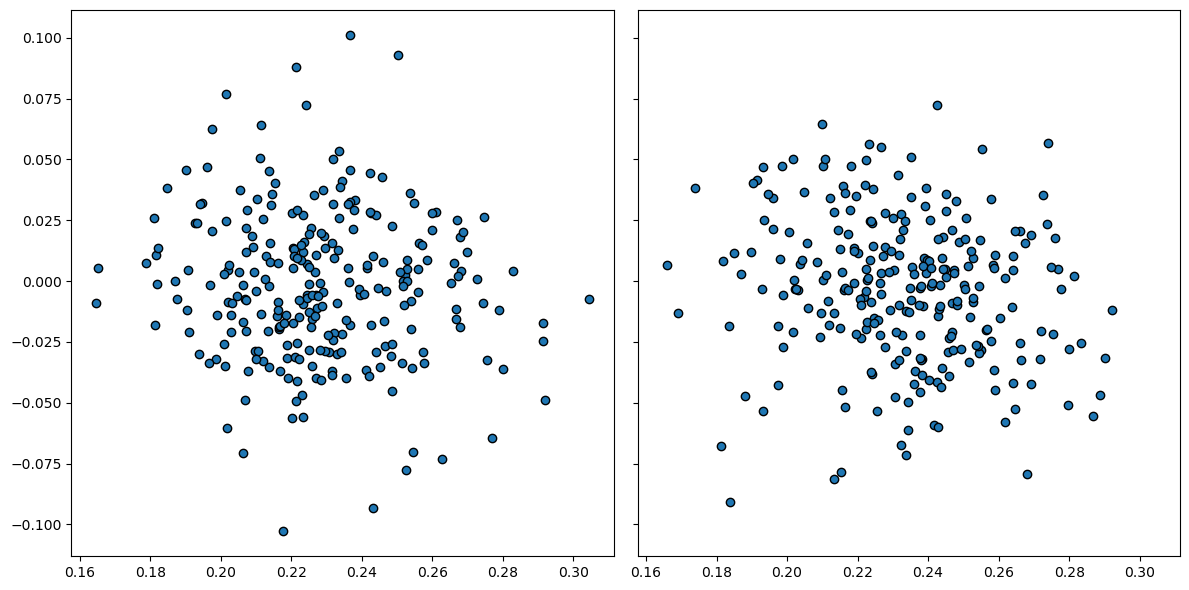

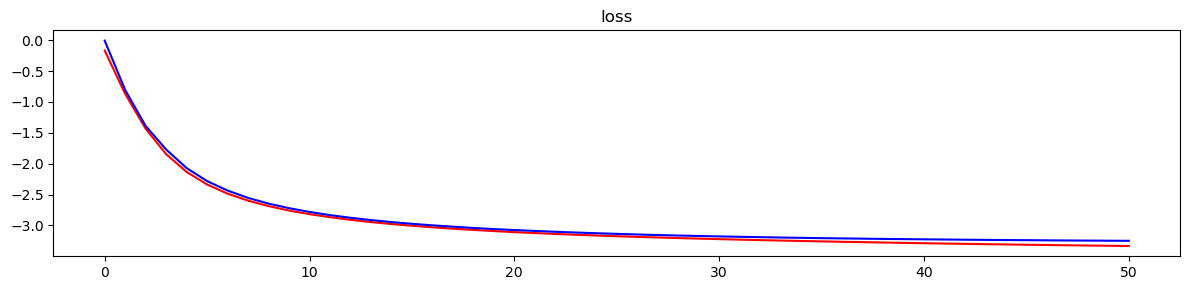

100%|███████████████████████████████████████| 5001/5001 [03:19<00:00, 25.04it/s]


In [111]:
train_mod_normalization(Mod_Normal_Flow_s4,opt_mod,train4_data,var_np4,test4_data,label=True,epochs=5001)

In [112]:
filename = './net/Mod_normal_4_val.pth'
torch.save(Mod_Normal_Flow_s4.state_dict(),filename)

In [113]:
filename = './net/Mod_normal_4_val.pth'
Mod_Normal_Flow_s4 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Mod_Normal_Flow_s4.load_state_dict(state)
Mod_Normal_Flow_s4.eval();

In [114]:
Inverse_flow_s4 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
opt_inv = torch.optim.Adam(Inverse_flow_s4.parameters(),lr=5e-3, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)

In [118]:
obs_fix4 = torch.tensor(obs_fix4,dtype=torch.float32)

/tmp/ipykernel_19886/3307326026.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_fix4 = torch.tensor(obs_fix4,dtype=torch.float32)


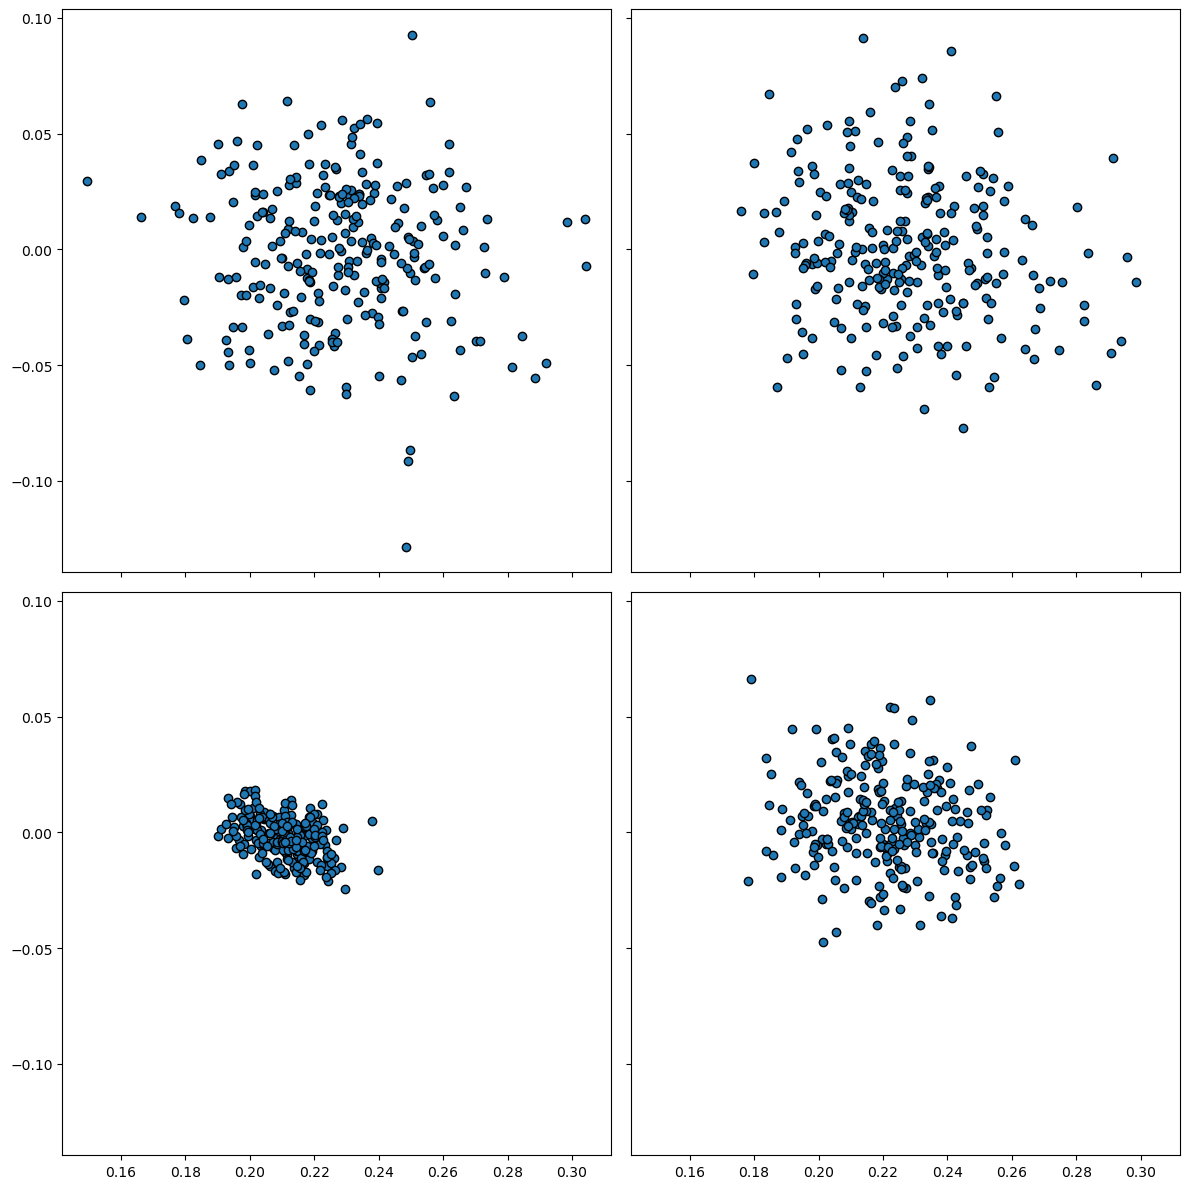

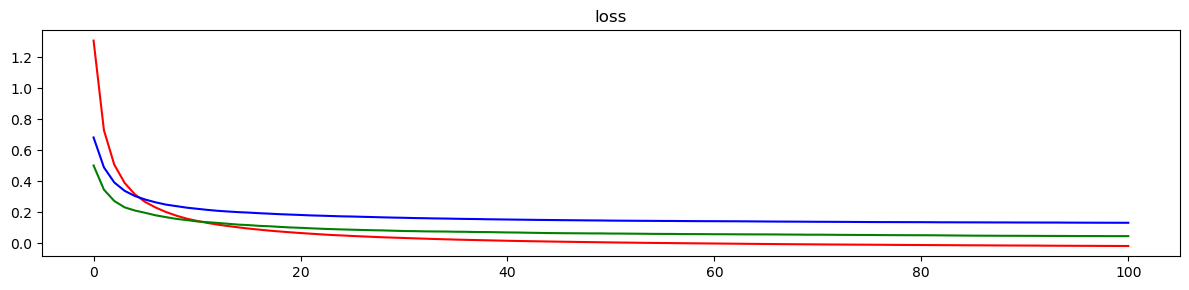

100%|█████████████████████████████████████| 10001/10001 [11:34<00:00, 14.40it/s]


In [119]:
cross_entropy4_1,cross_entropy4_2 = train_inverse_flow_validation(Obs_Normal_Flow_s4,Mod_Normal_Flow_s4,Inverse_flow_s4,opt_inv,train4_data,var_np4,obs_fix4,test4_data,ert_sample,label=True,epochs=10001)

In [120]:
filename = './net/Inverse_flow_s4_val.pth'
torch.save(Inverse_flow_s4.state_dict(),filename)

In [121]:
np.savetxt('./data/cross_entorpy1_4.txt',np.array(cross_entropy4_1))
np.savetxt('./data/cross_entorpy2_4.txt',np.array(cross_entropy4_2))

In [124]:
uni_dis = torch.distributions.uniform.Uniform(-torch.ones(INPUT_SIZE),torch.ones(INPUT_SIZE))
SAMPL_SIZE = 2000
model5_train = uni_dis.sample((25*SAMPL_SIZE,))
obs5_train = uni_dis.sample((25*SAMPL_SIZE,))
weight5_train = torch.randn((25*SAMPL_SIZE))

obs_fixed = torch.randn(SAMPL_SIZE,INPUT_SIZE,device=device)
obs_fixed[:] = torch.tensor(obs_fix4)[0]
obs_code = Obs_Normal_Flow_s4(obs_fixed.to(device))[0]

for num in range(25):
    rand_ert = torch.randn(SAMPL_SIZE,OUTPUT_SIZE,device=device)
    ert_fake_code, log_jac_det = Inverse_flow_s4(rand_ert,obs_code,rev=True,jac=False)
    ert_fake,log_jac_det2 = Mod_Normal_Flow_s4(ert_fake_code,rev=True,jac=False)
    weight5_train[num*SAMPL_SIZE:(num+1)*SAMPL_SIZE] = ((0.5*torch.sum(rand_ert**2,1) + log_jac_det + log_jac_det2)/OUTPUT_SIZE).detach().cpu()
    
    model5_train[num*SAMPL_SIZE:(num+1)*SAMPL_SIZE] = ert_fake.detach().cpu()
    obs5_train[num*SAMPL_SIZE:(num+1)*SAMPL_SIZE] = Forward_net(ert_fake)[0].detach().cpu()

weight5_train = weight5_train-weight5_train.mean()
weight5_train = torch.exp(weight5_train)

rand_ert = torch.randn(SAMPL_SIZE,OUTPUT_SIZE,device=device)
ert_fake_code, log_jac_det = Inverse_flow_s4(rand_ert,obs_code,rev=True,jac=False)
ert_fake, log_jac_det2 = Mod_Normal_Flow_s4(ert_fake_code,rev=True,jac=False)
weight5_test = ((0.5*torch.sum(rand_ert**2,1) + log_jac_det + log_jac_det2)/OUTPUT_SIZE).detach().cpu()
weight5_test = weight5_test-weight5_train.mean()
weight5_test = torch.exp(weight5_test)

model5_test = ert_fake.detach().cpu()
obs5_test = Forward_net(model5_test.to(device))[0].detach().cpu()

obs5_max = (np.max(obs5_train.numpy(),axis=0)).reshape(obs5_train.shape[1])
obs5_min = np.min(obs5_train.numpy(),axis=0).reshape(obs5_train.shape[1])
obs5_inter = obs5_max - obs5_min
obs5_train_normal = (obs5_train - obs5_min)/obs5_inter*2.-1.
obs5_test_normal = (obs5_test - obs5_min)/obs5_inter*2.-1.

BATCH_SIZE = 256
train5_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(obs5_train_normal,model5_train,weight5_train),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test5_data = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(obs5_test_normal,model5_test,weight5_test),
    batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

/tmp/ipykernel_19886/3599567957.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_fixed[:] = torch.tensor(obs_fix4)[0]


In [126]:
var_np5 = var_np/obs5_inter*2.
obs_fix5 = (obs_fix-obs5_min)/obs5_inter*2.-1.

# Step 5

In [123]:
Obs_Normal_Flow_s5 = Flow(INPUT_SIZE).cuda()
opt_obs = torch.optim.Adam(Obs_Normal_Flow_s5.parameters(), lr=5e-4, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)

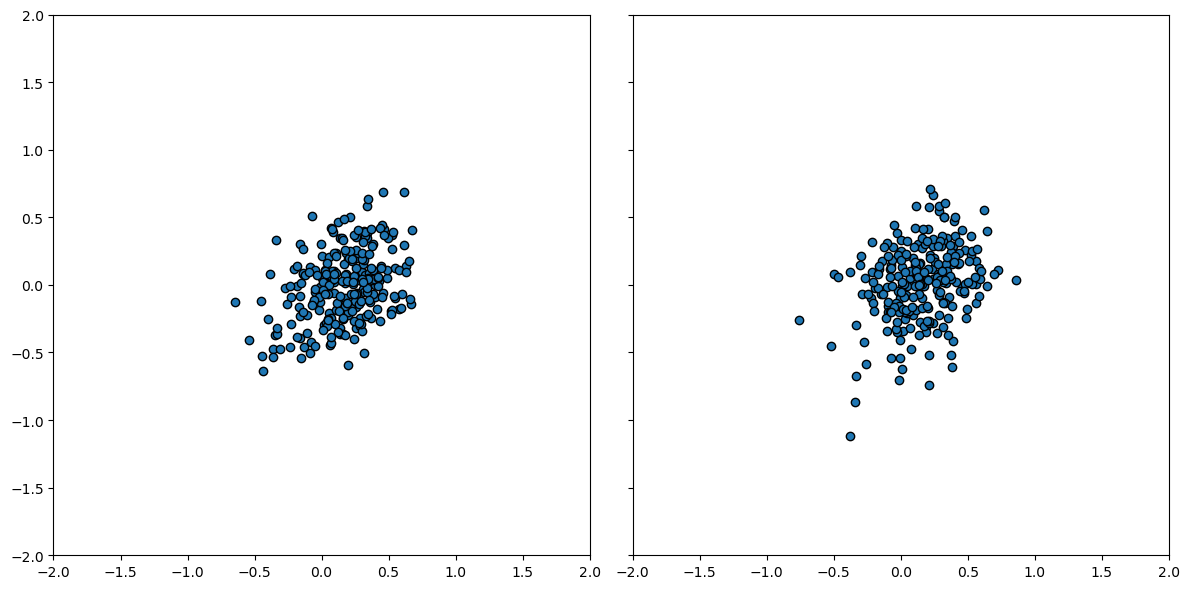

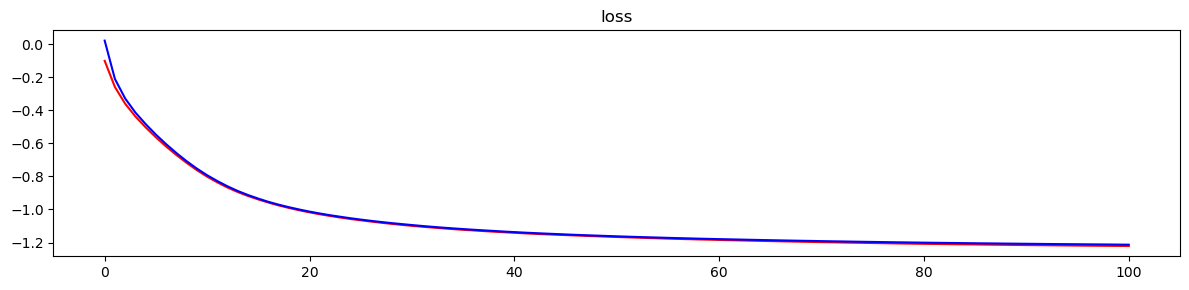

100%|█████████████████████████████████████| 10001/10001 [06:42<00:00, 24.87it/s]


In [127]:
train_obs_normalization(Obs_Normal_Flow_s5,opt_obs,train5_data,var_np5,test5_data,label=True,epochs=10001)

In [128]:
filename = './net/Obs_normal_5_val.pth'
torch.save(Obs_Normal_Flow_s5.state_dict(),filename)

In [129]:
filename = './net/Obs_normal_5_val.pth'
Obs_Normal_Flow_s5 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Obs_Normal_Flow_s5.load_state_dict(state)
Obs_Normal_Flow_s5.eval();

In [130]:
Mod_Normal_Flow_s5 = Flow(OUTPUT_SIZE).cuda()
opt_mod = torch.optim.Adam(Mod_Normal_Flow_s5.parameters(), lr=5e-3)

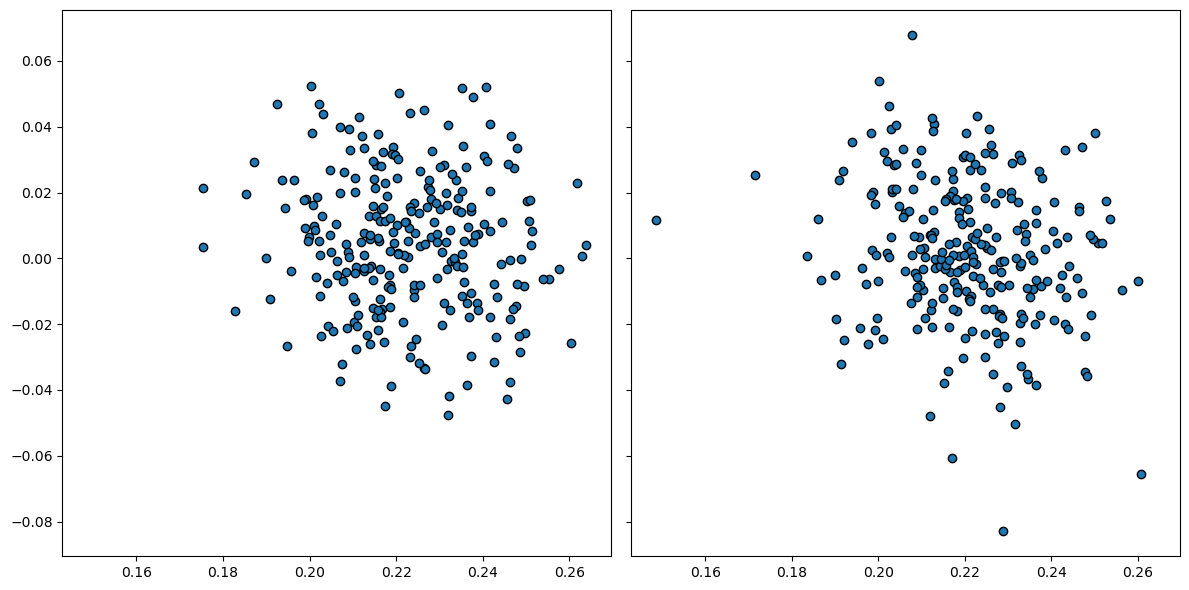

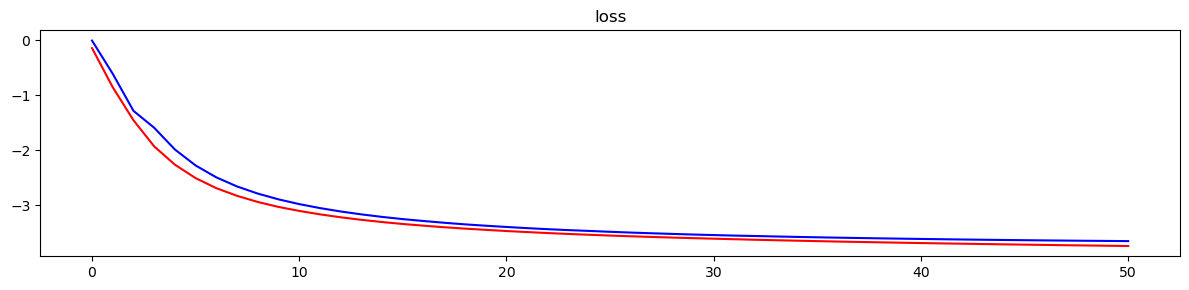

100%|███████████████████████████████████████| 5001/5001 [03:28<00:00, 24.02it/s]


In [131]:
train_mod_normalization(Mod_Normal_Flow_s5,opt_mod,train5_data,var_np5,test5_data,label=True,epochs=5001)

In [132]:
filename = './net/Mod_normal_5_val.pth'
torch.save(Mod_Normal_Flow_s5.state_dict(),filename)

In [133]:
filename = './net/Mod_normal_5_val.pth'
Mod_Normal_Flow_s5 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Mod_Normal_Flow_s5.load_state_dict(state)
Mod_Normal_Flow_s5.eval();

In [134]:
Inverse_flow_s5 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
opt_inv = torch.optim.Adam(Inverse_flow_s5.parameters(),lr=5e-3, betas=(0.8, 0.9),eps=1e-6, weight_decay=1e-5)

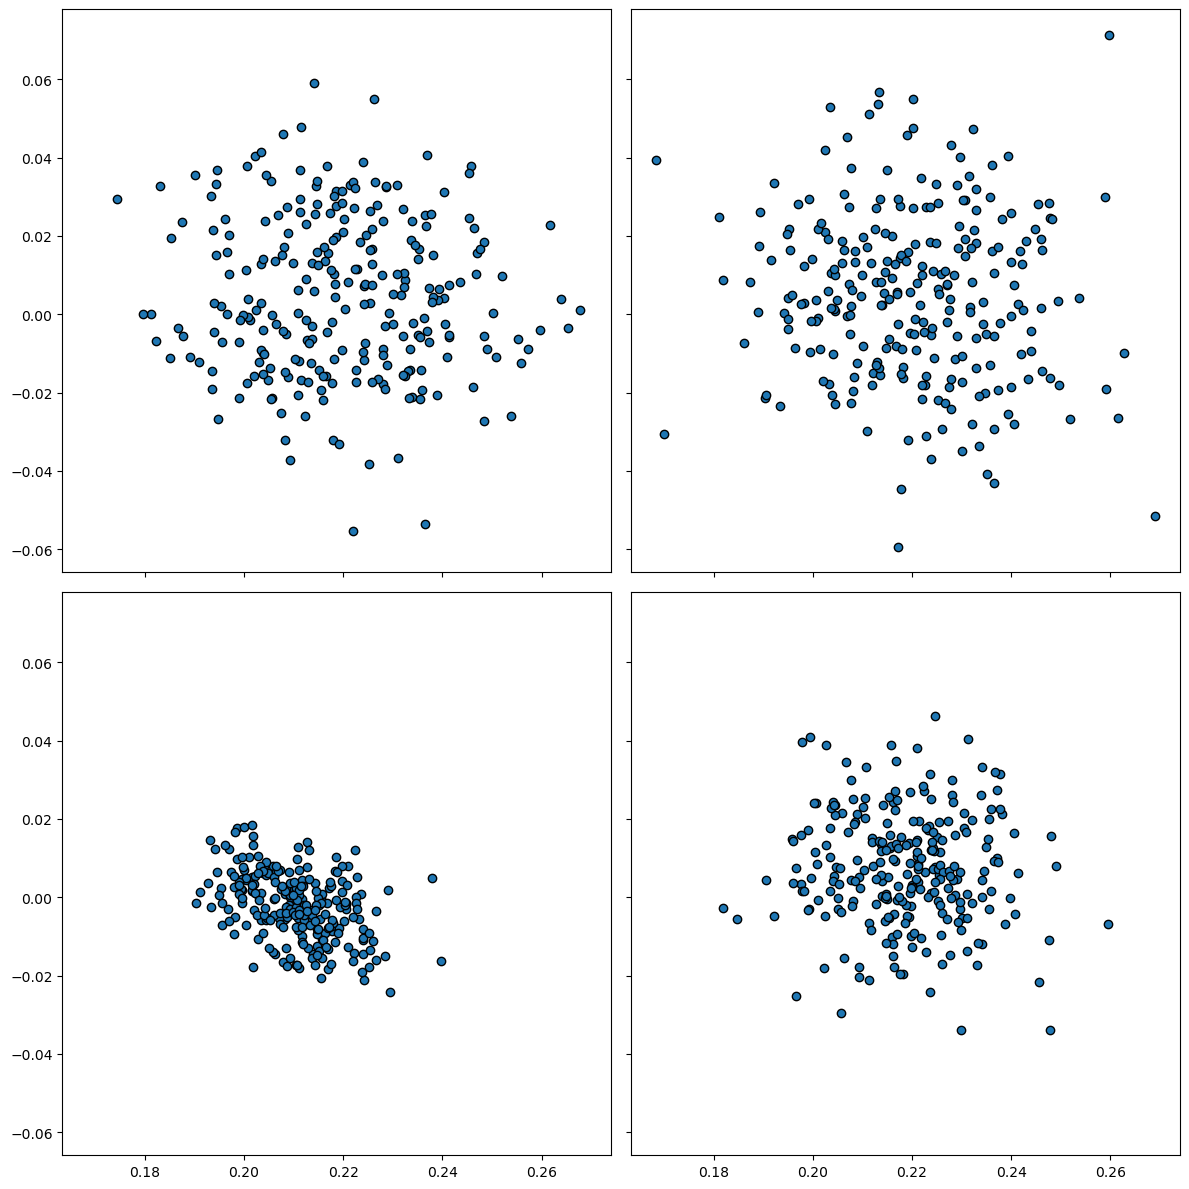

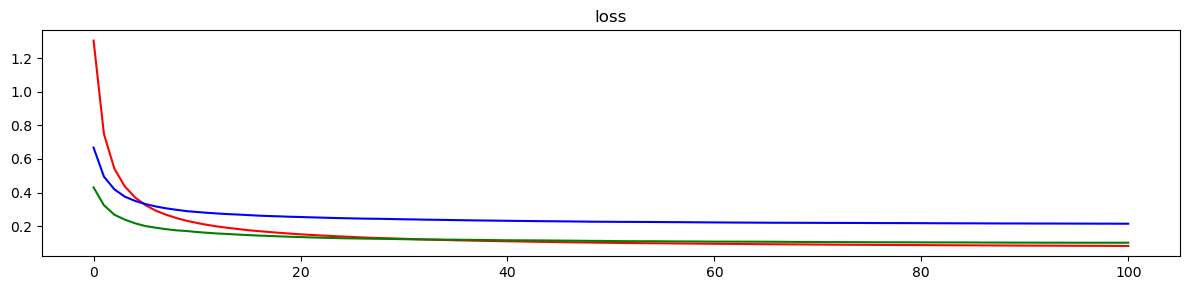

100%|█████████████████████████████████████| 10001/10001 [11:14<00:00, 14.82it/s]


In [135]:
cross_entropy5_1,cross_entropy5_2 = train_inverse_flow_validation(Obs_Normal_Flow_s5,Mod_Normal_Flow_s5,Inverse_flow_s5,opt_inv,train5_data,var_np5,obs_fix5,test5_data,ert_sample,label=True,epochs=10001)

In [136]:
filename = './net/Inverse_flow_s5_val.pth'
torch.save(Inverse_flow_s5.state_dict(),filename)

In [137]:
np.savetxt('./data/cross_entorpy1_5.txt',np.array(cross_entropy5_1))
np.savetxt('./data/cross_entorpy2_5.txt',np.array(cross_entropy5_2))

In [138]:
#np.savetxt('./data/obs2_min.txt',obs2_min)
#np.savetxt('./data/obs2_inter.txt',obs2_inter)
np.savetxt('./data/obs_fix2',obs_fix2)
np.savetxt('./data/obs_fix3',obs_fix3)
np.savetxt('./data/obs_fix4',obs_fix4)
np.savetxt('./data/obs_fix5',obs_fix5)

In [139]:
obs_fix = np.loadtxt('obs_val.txt')
obs_fix2 = np.loadtxt('./data/obs_fix2')
obs_fix3 = np.loadtxt('./data/obs_fix3')
obs_fix4 = np.loadtxt('./data/obs_fix4')
obs_fix5 = np.loadtxt('./data/obs_fix5')